### Tabnet hyperparamter tuning with hyperopt - regression

reference: 

- https://github.com/dreamquark-ai/tabnet/blob/develop/regression_example.ipynb
- https://arxiv.org/pdf/1908.07442.pdf
- http://hyperopt.github.io/hyperopt/
- 

#### steps:
1. download market data using yfinance: download S&P 500 ('^GSPC')
1. create target variable: calculate return 20-day max return (i.e. target in supervised learning problem).
   - for each date (T):
      - calculate the max price change in next 20 trading dates: price_change = (max{close price in T+1 to T+20} - {close price on T})/({close price on T})
1. feature engineering: engineer a few features
    - lag21: previous 21 day target
    - lag31: previous 31 day target
    - lag41: previous 41 day target
    - day price change: the difference between open and closing prices
        - (Close - Open)/Open
    - day max price change: the difference between high and low prices
        - (High-Low)/Open
    - one day close price change: day T close price versus day T-1 close price.
        - 100*({Close on T} - {Close on T-1})/{Close on T-1}
    - 10 day close price change: day T close price versus day T-10 close price.
        - 100*({Close on T} - {Close on T-10})/{Close on T-10}
    - 20 day close price change: day T close price versus day T-20 close price.
        - 100*({Close on T} - {Close on T-20})/{Close on T-20}
    - one day/10day/20day volume change
1. processing data and split data into training and testing subsets
1. setup the hyperparamter search space. 
  - the search space is defined based on 1) hyperparamters defined on [this page](https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#model-parameters) and the search space described in TabNet original [paper](https://arxiv.org/pdf/1908.07442.pdf)
  - I also added max number of epoches to search space, and I am not using any early stop (the early stop parametr in TabNet is `patience` - Number of consecutive epochs without improvement before performing early stopping.
1. use hyperopt to run the tuning process
  - I use tpe algorithm  - it is a Baysian search process with certain number of initial random trials.
  - here is a full walkthrough of hyperopt [pdf](https://iopscience.iop.org/article/10.1088/1749-4699/8/1/014008)
1. save trials and results 
- dump trials into a pickle file. this file can be helpful if I later want to run more trials of hyperparamter tuning.  

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
import yfinance as yf #to download stock price data

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np


import os
from pathlib import Path
import shutil

In [4]:
#initiate random seed
rand_seed=568
import random
def init_seed(random_seed):
    
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
init_seed(rand_seed)

In [5]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### download S&P 500 price data

In [6]:
ticker = '^GSPC'
cur_data = yf.Ticker(ticker)
hist = cur_data.history(period="max")
print(ticker, hist.shape, hist.index.min())

^GSPC (19721, 7) 1927-12-30 00:00:00


In [7]:
df=hist[hist.index>='2000-01-01'].copy(deep=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0,0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0,0


#### create the target variable: calcualte max return in next 20 trading days

In [8]:
#for each stock_id, get the max close in next 20 trading days
price_col = 'Close'
roll_len=20
new_col = 'next_20day_max'
target_list = []

df.sort_index(ascending=True, inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0


In [9]:
df_next20dmax=df[[price_col]].shift(1).rolling(roll_len).max()
df_next20dmax.columns=[new_col]
df = df.merge(df_next20dmax, right_index=True, left_index=True, how='inner')

df.dropna(how='any', inplace=True)
df['target']= 100*(df[new_col]-df[price_col])/df[price_col]  

In [10]:
df['target'].describe()

count    5479.000000
mean        2.450897
std         4.077561
min        -3.743456
25%         0.135604
50%         1.130147
75%         3.318523
max        44.809803
Name: target, dtype: float64

<AxesSubplot:>

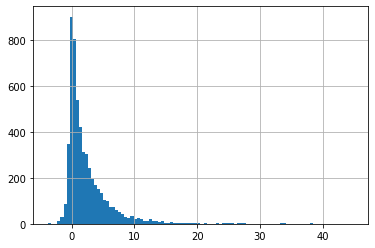

In [11]:
df['target'].hist(bins=100)

#### engineer features

- lag21: previous 21 day target
- lag31: previous 31 day target
- lag41: previous 41 day target
- day price change: the difference between open and closing prices
    - (Close - Open)/Open
- day max price change: the difference between high and low prices
    - (High-Low)/Open
- one day close price change: day T close price versus day T-1 close price.
    - 100*({Close on T} - {Close on T-1})/{Close on T-1}
- 10 day close price change: day T close price versus day T-10 close price.
    - 100*({Close on T} - {Close on T-10})/{Close on T-10}
- 20 day close price change: day T close price versus day T-20 close price.
    - 100*({Close on T} - {Close on T-20})/{Close on T-20}
- one day/10day/20day volume change
    
  


In [12]:
df['lag21']=df['target'].shift(21)
df['lag31']=df['target'].shift(31)
df['lag41']=df['target'].shift(41)

df['open_close_diff'] = df['Close'] - df['Open']
df['day_change']=(100*df['open_close_diff']/df['Open']).round(2)
df['day_max_change'] = (100*(df['High'] - df['Low'])/df['Open']).round(2)

#create a binary feature: 1 day change
#0: decrease; 1: increase
df['oneday_change']=(df['Close'].diff()>0)+1-1

df['10day_change']=df['Close'].diff(10)
df['20day_change']=df['Close'].diff(20)


df['oneday_volchange']=(df['Volume'].diff()>0)+1-1

df['10day_volchange']=df['Volume'].diff(10)
df['20day_volchange']=df['Volume'].diff(20)


df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target,lag21,...,lag41,open_close_diff,day_change,day_max_change,oneday_change,10day_change,20day_change,oneday_volchange,10day_volchange,20day_volchange
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,1394.459961,1412.489990,1384.790039,1409.280029,981000000,0,0,1465.150024,3.964435,NaN,...,NaN,14.820068,1.06,1.99,0,NaN,NaN,0,NaN,NaN
2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1038600000,0,0,1465.150024,3.976243,NaN,...,NaN,-0.160034,-0.01,1.21,0,NaN,NaN,1,NaN,NaN
2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1146500000,0,0,1465.150024,2.819712,NaN,...,NaN,15.849976,1.12,1.93,1,NaN,NaN,1,NaN,NaN


<AxesSubplot:>

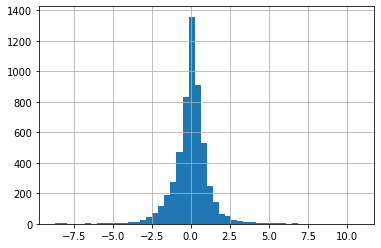

In [13]:
df['day_change'].hist(bins=50)

In [14]:
#convert day_change into categorical feature
#above 2- class 1; below -2 - class -1, in the middle - class0
df['day_change_cat']=0
df.loc[df['day_change']<=-2, 'day_change_cat']=-1
df.loc[df['day_change']>=2, 'day_change_cat']=1
df['day_change_cat'].value_counts()

 0    5095
-1     210
 1     174
Name: day_change_cat, dtype: int64

In [15]:
df.dropna(how='any', inplace=True)
print(df.shape, df.index.min())
df.head(3)

(5438, 22) 2000-03-30 00:00:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target,lag21,...,open_close_diff,day_change,day_max_change,oneday_change,10day_change,20day_change,oneday_volchange,10day_volchange,20day_volchange,day_change_cat
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-30,1508.520020,1517.380005,1474.630005,1487.920044,1193400000,0,0,1527.459961,2.657395,4.533823,...,-20.599976,-1.37,2.83,0,29.450073,106.160034,1,-288900000.0,-5200000.0,0
2000-03-31,1487.920044,1519.810059,1484.380005,1498.579956,1227400000,0,0,1527.459961,1.927158,4.339390,...,10.659912,0.72,2.38,1,34.109985,89.409912,1,-67700000.0,77100000.0,0
2000-04-03,1498.579956,1507.189941,1486.959961,1505.969971,1021700000,0,0,1527.459961,1.426987,2.309865,...,7.390015,0.49,1.35,1,49.339966,114.689941,0,100900000.0,-7300000.0,0


####  categorical data processing for TabNet

In [16]:
target='target'

In [17]:
df.dropna(how='any', inplace=True)
train = df.copy(deep=True)

In [18]:
categorical_columns = ['day_change_cat']
categorical_dims =  {}
for col in categorical_columns:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = l_enc.fit_transform(train[col].values)
    
    categorical_dims[col] = len(l_enc.classes_)

categorical_dims

day_change_cat 3


{'day_change_cat': 3}

In [19]:
categorical_columns, categorical_dims

(['day_change_cat'], {'day_change_cat': 3})

#####  Define categorical features for categorical embeddings

In [20]:
unused_feat = ['Dividends', 'Stock Splits', 'next_20day_max',
               'open_close_diff', 'day_change' ]

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [21]:
print(features, len(features))

['Open', 'High', 'Low', 'Close', 'Volume', 'lag21', 'lag31', 'lag41', 'day_max_change', 'oneday_change', '10day_change', '20day_change', 'oneday_volchange', '10day_volchange', '20day_volchange', 'day_change_cat'] 16


In [22]:
cat_idxs

[15]

In [23]:
cat_dims

[3]

#### Split data from training

In [40]:
train.shape

(5438, 22)

In [42]:
X_train = train[features].values[:-1000,:]
y_train = train[target].values[:-1000]


X_test = train[features].values[-950:, ]
y_test = train[target].values[-950:]

In [44]:
X_train.shape, X_test.shape

((4438, 16), (950, 16))

####  hyperopt setup - define search space and score function


In [76]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, anneal, rand

In [77]:
search_space = { 
    
                 'n_d': hp.choice('n_d',[8, 16, 24, 32, 64, 128]), #Nd and Na are chosen from {8, 16, 24, 32, 64, 128},
                 'n_steps': hp.choice('n_steps',[3,4,5,6,7,8,9,10]),#Nsteps is chosen from {3, 4, 5, 6, 7, 8, 9, 10}
                 'gamma':hp.choice('gamma', [1.0, 1.2, 1.5, 2.0]),#γ is chosen from {1.0, 1.2, 1.5, 2.0}
                 'n_independent':hp.choice('n_independent', [1,2,3,4,5] ),
                 'n_shared':hp.choice('n_shared', [1,2,3,4,5]),
                 'momentum':  hp.choice('momentum', np.round(np.arange(0.01, 0.4, 0.01),3)), #Momentum for batch normalization, typically ranges from 0.01 to 0.4 (default=0.02)
                 #momentum mB., and mB is chosen from {0.6, 0.7, 0.8, 0.9, 0.95, 0.98}. 
                 'lambda_sparse': hp.choice('lambda_sparse', [0, 0.000001, 0.0001, 0.001, 0.01, 0.1]), #λsparse is chosen from {0, 0.000001, 0.0001, 0.001, 0.01, 0.1}
                 'optimizer_fn': hp.choice('optimizer_fn', ['Adam', 'RMSprop', 'SGD']),
                 'lr': hp.choice('lr', [0.005, 0.01, 0.02, 0.025]), #optimizer. the learning rateis chosen from {0.005, 0.01.0.02, 0.025}, 
                 'optimizer_momentum': hp.choice('optimizer_momentum', [0.4, 0.8, 0.9, 0.95]),#optimizer ????
                 #the decay rate is chosen from {0.4, 0.8, 0.9, 0.95} and the decay iterations is chosen from {0.5k, 2k, 8k, 10k, 20k}
                 'weight_decay':hp.choice('weight_decay', [0, 0.5, 0.001, 0.0001] ),#optimizer.  the decay rate is chosen from {0.4, 0.8, 0.9, 0.95} a
                 'scheduler_fn':hp.choice('scheduler_fn', ['StepLR', 'CosineAnnealingWarmRestarts', 'ReduceLROnPlateau']),
                 'fn_step_size':hp.choice('fn_step_size', [3, 5, 10, 15]), 
                 'fn_gamma':hp.choice('fn_gamma', np.round(np.arange(0.1, 0.95, 0.01),3)),
                 'fn_T_0':hp.choice('fn_T_0', [3, 5, 10, 15]), 
                 'fn_eta_min':hp.choice('fn_eta_min', np.round(np.arange(0.0001, 0.001, 0.0001),4)),
                 'max_epochs':hp.choice('max_epochs', range(30, 201, 1)),
                 'batch_size':hp.choice('batch_size', [256, 512, 1024, 2048, 4096, 8192, 16384, 32768]),#B is chosen from {256, 512, 1024, 2048, 4096, 8192, 16384, 32768}
                 'virtual_batch_size':hp.choice('virtual_batch_size', [256, 512, 1024, 2048, 4096]),#BV is chosen from {256, 512, 1024, 2048, 4096}
                 'patience':hp.choice('patience', [0]),
                  }

n_trials = 100
n_random_trials = 30

In [78]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error
import copy

def score(params):
    
    tab_params = {}
    tab_params['n_d'] = params['n_d']
    tab_params['n_a'] = params['n_d'] #set n_a equals n_d according to official document
    tab_params['seed']= rand_seed #set random seed for reproduciablity
    tab_params['gamma'] = params['gamma']
    tab_params['n_independent'] = params['n_independent']
    tab_params['n_shared'] = params['n_shared']
    tab_params['momentum'] = params['momentum']
    tab_params['lambda_sparse'] = params['lambda_sparse']
    tab_params['cat_idxs']=cat_idxs #no categorical features
    tab_params['cat_dims']=cat_dims
    tab_params['cat_emb_dim']=1,
    
    lr =params['lr']
    weight_decay =params['weight_decay']
    optimizer_momentum =params['optimizer_momentum']
    optimizer_fn=params['optimizer_fn']
    
    if optimizer_fn=='Adam':
        tab_params['optimizer_params'] = dict(lr=lr, weight_decay=weight_decay)
        tab_params['optimizer_fn'] = torch.optim.Adam
    elif optimizer_fn == 'RMSprop':
        tab_params['optimizer_params'] = dict(lr=lr, momentum=optimizer_momentum, weight_decay=weight_decay)
        tab_params['optimizer_fn'] = torch.optim.RMSprop
    elif optimizer_fn == 'SGD':
        tab_params['optimizer_params'] = dict(lr=lr, momentum=optimizer_momentum, weight_decay=weight_decay)
        tab_params['optimizer_fn'] = torch.optim.SGD
   
    scheduler_fn = params['scheduler_fn']
    fn_step_size = params['fn_step_size']
    fn_gamma = params['fn_gamma']
    fn_T_0 = params['fn_T_0']
    fn_eta_min = params['fn_eta_min']
    
    if scheduler_fn== 'StepLR':
        tab_params['scheduler_params'] ={'gamma':fn_gamma, 'step_size':fn_step_size}
        tab_params['scheduler_fn'] = torch.optim.lr_scheduler.StepLR
    elif scheduler_fn== 'CosineAnnealingWarmRestarts':
        tab_params['scheduler_params'] ={'T_0':fn_T_0, 'eta_min':fn_eta_min}
        tab_params['scheduler_fn'] = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
    elif scheduler_fn== 'ReduceLROnPlateau':
        tab_params['scheduler_params'] ={'mode':'min', 'min_lr':fn_eta_min}
        tab_params['scheduler_fn'] = torch.optim.lr_scheduler.ReduceLROnPlateau
        
    tab_params['epsilon']=1e-15 #default. leave untouched
    tab_params['verbose']=0 #no verbose
    
    batch_size=params['batch_size'] 
    mini_batch_size=params['virtual_batch_size'] 
    if mini_batch_size>batch_size:
        mini_batch_size=batch_size
    
    #--add fit params---
    full_params = copy.deepcopy(tab_params)
    
    max_epochs = params['max_epochs']
    patience = params['patience']
    full_params['max_epochs'] = max_epochs
    full_params['batch_size'] = batch_size
    full_params['virtual_batch_size'] = mini_batch_size
    full_params['patience'] = patience
    
    params_list.append(copy.deepcopy(full_params)) 
    
    #-----------------------------------------------------
    #---start training: this part can easily be replaced with k-fold list----
    
    i = len(params_list)
    
    
    #initiate classifier - need to re-initiate for each Train-Test pair
    clf = TabNetRegressor(**tab_params)
    clf.fit(
        X_train=X_train, y_train=y_train.reshape(-1,1),
        eval_set=[(X_train, y_train.reshape(-1,1))],
        eval_name=['train'],
        eval_metric=['mse'],
        max_epochs=max_epochs, patience=patience,
        batch_size=batch_size, virtual_batch_size=mini_batch_size,
        num_workers=0,
        drop_last=False
    ) 

    preds = clf.predict(X_test).flatten()
    #print(preds)
    loss = mean_squared_error(y_pred=preds, y_true=y_test)

    
        
    df_pred = pd.DataFrame({'y_true':y_test, 'y_pred':preds})
    
    metric_list.append([i, full_params, loss] )
    df_pred.to_csv(save_dir.joinpath(f'trial_{i}'), sep='|', index=False, compression='bz2')
    
    
    return {'loss': loss, 'status': STATUS_OK}

In [79]:
from functools import partial
def optimize(space, evals, cores, trials, optimizer=tpe.suggest, random_state=1234, n_startup_jobs=50):
    space['seed']= random_state
    algo = partial(optimizer, n_startup_jobs=n_startup_jobs)
    best = fmin(score, space, algo=algo, max_evals=evals, trials = trials)
    return best

#### run hyperparamter tuning

In [48]:
params_list = []
metric_list = []
trials = Trials()

In [72]:
save_dir=Path('hyper_tune/tabnet')

In [73]:
optimize(search_space,
          evals = 10,
          optimizer=tpe.suggest,
          cores = 4,
          trials = trials, random_state=rand_seed, 
          n_startup_jobs=5)

No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, last training weights will be used.                                               
No early stopping will be performed, las

{'batch_size': 6,
 'fn_T_0': 0,
 'fn_eta_min': 7,
 'fn_gamma': 5,
 'fn_step_size': 0,
 'gamma': 3,
 'lambda_sparse': 0,
 'lr': 1,
 'max_epochs': 30,
 'momentum': 38,
 'n_d': 1,
 'n_independent': 1,
 'n_shared': 3,
 'n_steps': 4,
 'optimizer_fn': 1,
 'optimizer_momentum': 0,
 'patience': 0,
 'scheduler_fn': 2,
 'virtual_batch_size': 3,
 'weight_decay': 1}

##### save trials and results 

- dump trials into a pickle file. this file can be helpful if I later want to run more trials of hyperparamter tuning.

In [81]:
save_dir.parent

WindowsPath('hyper_tune')

In [83]:
import joblib
joblib.dump(trials, save_dir.parent.joinpath('tabnet.pkl'))

['hyper_tune\\tabnet.pkl']

In [87]:
pd.DataFrame(metric_list, columns=['trial_id', 'params', 'loss']).to_excel(save_dir.parent.joinpath('tabnet.xlsx'))